Todo o *dataset* servirá como dados de treino para o modelo de aprendizado de máquina. O conjunto de dados de teste será o *dataset* contendo o 100 *malwares* atuais.

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [3]:
df = pd.read_csv("../2_Datasets_Prepared/Drebin215_2012_Prepared.csv")
df.shape

(7259, 215)

In [4]:
df['class'].value_counts()

0    5539
1    1720
Name: class, dtype: int64

1 >> 1399

0 >> 5539

Nivelamos a quantidade de *malwares* (i.e., 1720 >> 1399) para ficar com a mesma quantidade que o outro *dataset*, para evitar que um modelo treine mais que outro.

### Conjunto de dados de Treino (100%)

In [10]:
# selecionando aleatoriamente 30% dos dados de amostras benignas e malignas para validação
Bval = df[df["class"] == 0].sample(n=5539, random_state=42)
Mval = df[df["class"] == 1].sample(n=1399, random_state=42)
train = pd.concat([Bval,Mval])
indexes = train["class"].index.tolist()
train = shuffle(train)
train = train.reset_index()
train.drop(columns=["index"], inplace=True)
x_train = train.drop(columns=["class"])
y_train = train["class"]

### Conjunto de dados de teste

In [15]:
test = pd.read_csv("../2_Datasets_Prepared/Malwares_2020_2022_Prepared.csv")
test.shape

(100, 10501)

In [16]:
test.head()

API_MIN  API  Permission :: ACCESS_NETWORK_STATE  \
0       16   22                                   1   
1       23   30                                   1   
2       22   29                                   1   
3       22   29                                   1   
4       23   30                                   1   

   Permission :: WRITE_EXTERNAL_STORAGE  Permission :: C2D_MESSAGE  \
0                                     1                          1   
1                                     1                          1   
2                                     0                          0   
3                                     0                          0   
4                                     1                          1   

   Permission :: GET_TASKS  Permission :: INTERNET  \
0                        1                       1   
1                        0                       1   
2                        0                       1   
3                        0                       1   
4                        0                       1   

   Permission :: GET_APP_OPS_STATS  Permission :: RECEIVE_BOOT_COMPLETED  \
0                                1                                     1   
1                                0                                     1   
2                                0                                     0   
3                                0                                     0   
4                                0                                     1   

   Permission :: WAKE_LOCK  Permission :: READ_SETTINGS  \
0                        1                            1   
1                        1                            1   
2                        1                            1   
3                        1                            1   
4                        1                            1   

   Permission :: ACCESS_COARSE_LOCATION  Permission :: SYSTEM_ALERT_WINDOW  \
0                                     1                                  1   
1                                     0                                  0   
2                                     0                                  0   
3                                     0                                  0   
4                                     1                                  0   

   Permission :: ACCESS_WIFI_STATE  Permission :: RECEIVE_USER_PRESENT  \
0                                1                                   1   
1                                1                                   0   
2                                1                                   0   
3                                1                                   0   
4                                1                                   0   

   Permission :: CHANGE_WIFI_STATE  Permission :: READ_PHONE_STATE  \
0                                1                               1   
1                                1                               1   
2                                0                               0   
3                                0                               0   
4                                0                               1   

   Permission :: READ_CALL_LOG  Permission :: INSTALL_SHORTCUT  \
0                            1                               1   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   Permission :: GET_PACKAGE_SIZE  Permission :: ACCESS_FINE_LOCATION  \
0                               1                                   1   
1                               0                                   0   
2                               0                                   0   
3                               0                                   0   
4                

### Treinamento do modelo Random Forest Classifier

In [11]:
RF = RandomForestClassifier()

In [12]:
RF.fit(x_train,y_train)

RandomForestClassifier()

In [46]:
print("Curva ROC >> ", roc_auc_score(y_test, RF.predict(x_test))*100, "%")

Curva ROC >>  88.21483707791356 %


### Otimização de Hiperparâmetros

In [47]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

O_RF = RandomizedSearchCV(RF, random_grid, random_state=42, scoring="roc_auc",cv = 5, n_iter=100, n_jobs=-1, verbose=2).fit(x_validation,y_validation)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; 

In [48]:
O_RF.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

In [49]:
ORF = RandomForestClassifier(**O_RF.best_params_)

In [50]:
ORF.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=1800)

In [51]:
print("Curva ROC >> ", roc_auc_score(y_test, ORF.predict(x_test))*100, "%")

Curva ROC >>  89.23022598870057 %


/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use o

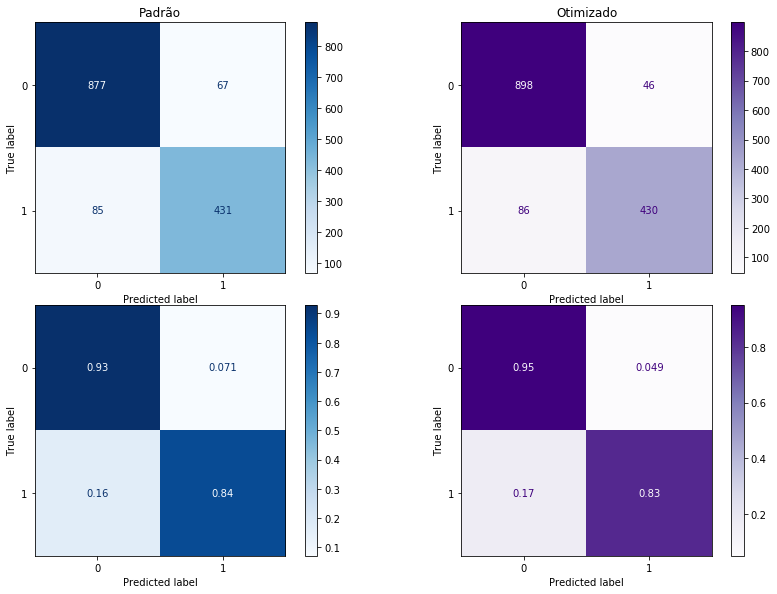

In [52]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
plt.tight_layout()
ax1.set(title="Padrão")
ax2.set(title="Otimizado")
plot_confusion_matrix(RF, x_test, y_test,ax=ax1, cmap = "Blues", values_format="d")
plot_confusion_matrix(ORF, x_test, y_test, ax=ax2, cmap= "Purples", values_format="d")
plot_confusion_matrix(RF, x_test, y_test,ax=ax3, cmap = "Blues", normalize = "true")
plot_confusion_matrix(ORF, x_test, y_test, ax=ax4, cmap= "Purples", normalize = "true")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=be34dc1b-561d-4c90-bae1-66eed919bb55' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>